# Analysis of the L1-21-J impact event on the Moon

*"Location, orbit and energy of a meteoroid impacting the moon during the Lunar Eclipse of January 21, 2019* by Jorge I. Zuluaga, Pablo A. Cuartas, Rodrigo Leiva, Jonathan Ospina, Sergio López, Fritz Pichardo & Karl Peña

In [899]:
BDIR="./"
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from scipy.optimize import minimize
from scipy.interpolate import interp1d as interpolate
from scipy.integrate import quad as integrate
import statistics as stats
import spiceypy as spy
from copy import deepcopy
#spy.furnsh(BDIR+"Dynamics/de430.bsp")
spy.furnsh(BDIR+"Dynamics/naif0012.tls")
spy.furnsh(BDIR+"Dynamics/pck00010.tpc")
spy.furnsh(BDIR+"Dynamics/moon_pa_de421_1900-2050.bpc")
from mpl_toolkits.basemap import Basemap as Map,shiftgrid as Grid

%matplotlib nbagg

## Useful routines

In [477]:
#Constants

DEG=np.pi/180
RAD=1/DEG

#Macros
norm=np.linalg.norm

#Routines
def str2vec(str):
    v=np.array([float(x) for x in str.split(" ")])
    return v
def angle(u,v):
    return np.arccos(np.dot(u,v)/(norm(u)*norm(v)))*180/np.pi

def randomX(xs,ps,N=100):
    """
        Generate random values of x given a normalized histogram (ps)
    """
    Ps=np.array([ps[:i].sum() for i in range(len(ps))])
    Fi=interpolate(Ps,xs)
    u=np.random.rand(N,1)
    us=Ps.min()+u*(Ps.max()-Ps.min())
    xrs=Fi(us)
    return xrs

def ipercs(xs,ps,qpercs):
    Ps=np.array([ps[:i].sum() for i in range(len(ps))])
    fi=interpolate(Ps,xs)
    return fi(np.array(qpercs)/100.0)

def Gmag(coefs,r=1,g=1,b=1,x=1,y=1):
    """
    coefs: Coefficients
    r,g,b: Counts in each band
    """
    mG=coefs[0]+coefs[1]*np.log(r)+coefs[2]*np.log(g)+coefs[3]*np.log(b)
    return mG                                         

def chiSquare(coefs,stars=None,verbose=False):
    chisq=0
    for ind in stars.index[1:]:
        star=stars.loc[ind]
        Gteo=Gmag(coefs,star["Red"],star["Blue"],star["Green"])
        Gobs=float(star["G"])
        if verbose:print(f"{star['Starname']}:Teo={Gteo},Obs={Gobs},dM={np.abs(Gteo-Gobs)}")
        dG=0.05
        chisq+=(Gteo-Gobs)**2/dG**2
    return chisq

## General conditions at the time of the picture

In [3]:
MOON_RADIUS=1738.1 #km
rearth_eclipse=str2vec("-7.5021317702e+07 1.2785094980e+08 -1.3532876863e+04")
rmoon_eclipse=str2vec("-7.5201388484e+07 1.2816006403e+08 -1.1401697207e+04")
MOON_DISTANCE=norm(rmoon_eclipse-rearth_eclipse)

## Images and instruments

In [4]:
#La Loma
LALOMA_F=0.73
LALOMA_FL=2700.0 #mm
LALOMA_D=635 #mm
ZWO_COLS=4656.0 #px
ZWO_ROWS=3520.0 #px
ZWO_WIDTH=17.5 #mm
ZWO_HEIGHT=13.4 #mm

In [5]:
#Theoretical spatial resolution at moon distance
pxsize=ZWO_WIDTH/(LALOMA_F*LALOMA_FL)/ZWO_COLS
pxsize_km=pxsize*MOON_DISTANCE
print(f"Theoretical angular resolution = {pxsize*180/np.pi*3600} arcsec")
print(f"Theoretical linear resolution = {pxsize_km} km")

Theoretical angular resolution = 0.3933358994645062 arcsec
Theoretical linear resolution = 0.6822008888314954 km


In [6]:
#At 70 degrees inclination
pxsize_inc=pxsize_km/np.cos(70*DEG)
print(f"Theoretical linear resolution (@70 deg) = {pxsize_inc} km")

Theoretical linear resolution (@70 deg) = 1.994621960560695 km


## Orbital analysis

### Test trajectories and their probabilities

In [7]:
data_rays=np.loadtxt(BDIR+"Data/rays-lat_6.62000e+00__lon_1.11200e+01.data.phys")
data_rays_prob=np.loadtxt(BDIR+"Data/rays-lat_6.62000e+00__lon_1.11200e+01.data.prob")

### Posterior probability distribution of key properties 

In [426]:
properties=[
    dict(indice=0,property="elevation",factor=30),
    dict(indice=2,property="vimp",factor=5),
    dict(indice=1,property="azimuth",factor=50)
]
pprob=data_rays_prob[:,7]
print("Computed rays:",len(pprob))
for qprop in properties:
    print(f"Computing ppd for {qprop['property']}")
    xs=data_rays[:,qprop["indice"]]
    xun=np.unique(xs)
    Nun=len(xun)
    print("\tUnique values of property:",Nun)

    # Range of elevations                                                                                                                                                                                                                                     
    xmin=xs.min()
    xmax=xs.max()
    print("\tRanges:",xmin,xmax)

    # Create boxes                                                                                                                                                                                                                                            
    Nb=int(Nun/qprop["factor"])
    print("\tSampling points:",Nb)
    xb=np.linspace(xmin,1.01*xmax,Nb,endpoint=False)
    dxb=xb[1]-xb[0]

    # Compute probabilities                                                                                                                                                                                                                                   
    P=0
    hb=np.zeros(Nb)
    for i,x in enumerate(xs):
        p=pprob[i]
        P+=p
        n=int((x-xmin)/dxb)
        hb[n]+=p

    hb=np.array(hb)
    hb/=P

    #Save histogram
    fname=BDIR+f"Data/{qprop['property']}-marginal.dat"
    print(f"\tSaving {fname}")
    np.savetxt(fname,np.vstack((xb,hb)).transpose())

Computed rays: 29467
Computing ppd for elevation
	Unique values of property: 498
	Ranges: 0.27798 83.332
	Sampling points: 16
	Saving ./Data/elevation-marginal.dat
Computing ppd for vimp
	Unique values of property: 100
	Ranges: 2.7972 44.058
	Sampling points: 20
	Saving ./Data/vimp-marginal.dat
Computing ppd for azimuth
	Unique values of property: 498
	Ranges: 0.27282 359.06
	Sampling points: 9
	Saving ./Data/azimuth-marginal.dat


### Impact velocity statistics

In [436]:
#Posterior probability distribution of impact velocitiesç
data=np.loadtxt(BDIR+"Data/vimp-marginal.dat")
vimp=data[:,0]
ps=data[:,1]
v1,vm,v2=ipercs(vimp,ps,[15.0,50.0,85.0])
mv=vm-v1;pv=v2-vm

vimps=deepcopy(vimp)
pvs=deepcopy(ps)

<IPython.core.display.Javascript object>


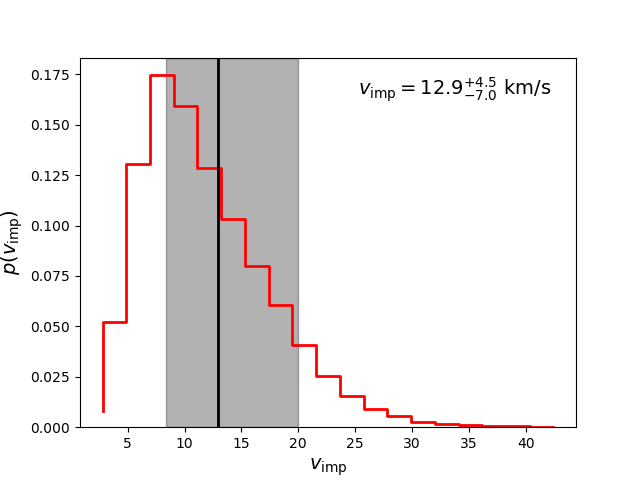

In [437]:
fig=plt.figure()
ax=fig.gca()

ax.step(vimp,ps,color='r',lw=2)

ax.set_xlabel(r"$v_{\rm imp}$",fontsize=14)
ax.set_ylabel(r"$p(v_{\rm imp})$",fontsize=14)

ax.axvspan(v1,vm,color='k',alpha=0.3)
ax.axvline(vm,color='k',lw=2)
ax.axvspan(vm,v2,color='k',alpha=0.3)

#ax.set_title("L1-J-21 Impact Velocity",fontsize=18)

ax.text(0.95,0.95,r"$v_{\rm imp}=%.1lf^{+%.1lf}_{-%.1lf}$ km/s"%(vm,mv,pv),
        transform=ax.transAxes,ha='right',va='top',fontsize=14)

ymin,ymax=ax.get_ylim()
ax.set_ylim((0,ymax))
fig.savefig(BDIR+"FigurasArticulo/l21j-vimp-ppd.png")

<IPython.core.display.Javascript object>


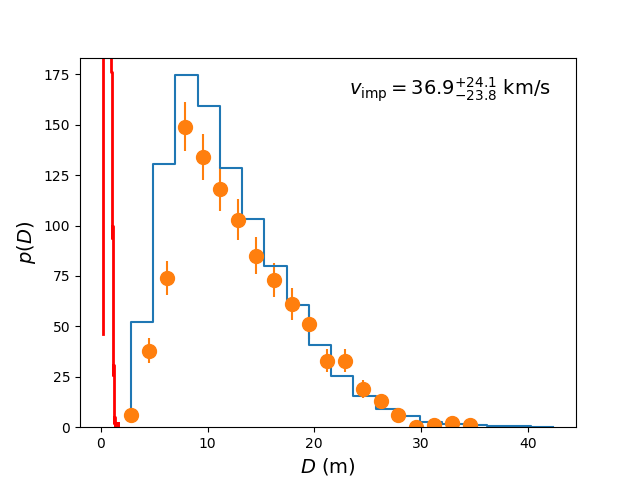

(0, 183.3035032160176)

In [438]:
#Generate random velocities
N=1000.0
nbin=20
vrs=randomX(vimp,pvs,N)
hs,xs=np.histogram(vrs,nbin)
xms=xs[:-1]
dx=xs[1]-xs[0]
dhs=np.sqrt(hs)

#Check statistical properties of sample
fig=plt.figure()
ax=fig.gca()

ax.step(vimp,N*ps)
ax.errorbar(xms,hs,dhs,ls='None',marker='o',ms=10)

ax.set_xlabel(r"$v_{\rm imp}$",fontsize=14)
ax.set_ylabel(r"$p(v_{\rm imp})$",fontsize=14)
ymin,ymax=ax.get_ylim()
ax.set_ylim((0,ymax))

### Incident angle statistics

In [440]:
#Posterior probability distribution of impact velocities
data=np.loadtxt(BDIR+"Data/elevation-marginal.dat")
vimp=data[:,0]
ps=data[:,1]
v1,vm,v2=ipercs(vimp,ps,[15.0,50.0,85.0])
mv=vm-v1;pv=v2-vm
angles=deepcopy(vimp)
pas=deepcopy(ps)

<IPython.core.display.Javascript object>


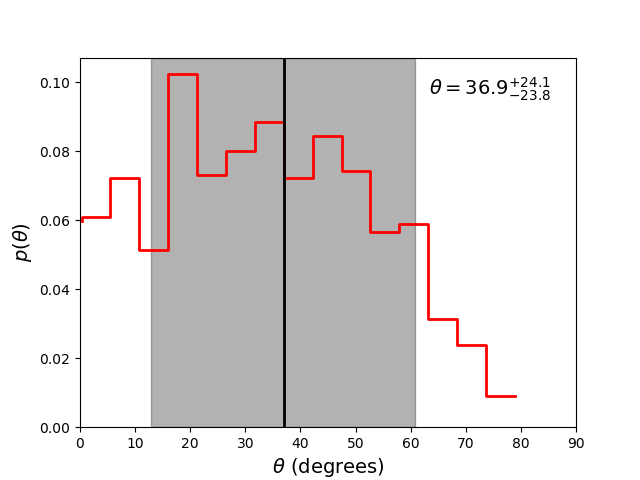

In [434]:
fig=plt.figure()
ax=fig.gca()

ax.step(vimp,ps,color='r',lw=2)

ax.set_xlabel(r"$\theta$ (degrees)",fontsize=14)
ax.set_ylabel(r"$p(\theta)$",fontsize=14)

ax.axvspan(v1,vm,color='k',alpha=0.3)
ax.axvline(vm,color='k',lw=2)
ax.axvspan(vm,v2,color='k',alpha=0.3)

#ax.set_title("L1-J-21 Impact Velocity",fontsize=18)

ax.text(0.95,0.95,r"$\theta=%.1lf^{+%.1lf}_{-%.1lf}$"%(vm,mv,pv),
        transform=ax.transAxes,ha='right',va='top',fontsize=14)

ymin,ymax=ax.get_ylim()
ax.set_ylim((0,ymax))
ax.set_xlim((0,90))
fig.savefig(BDIR+"FigurasArticulo/l21j-elevation-ppd.png")

### Maps of proveneance

In [305]:
print(f"Computing map for a-e")
      
qs=data_rays[:,9]
es=data_rays[:,10]
aes=qs/(1-es)
Nt=len(qs)

qmin=qs.min();qmax=qs.max()
emin=es.min();emax=es.max()
amin=aes.min();amax=aes.max()

qmin,qmax,emin,emax,amin,amax

Computing map for a-e


(0.004145345615760619,
 1.012569504327674,
 0.002130122467894431,
 0.9959151310360084,
 0.5384744532054262,
 39.891426002107245)

In [306]:
amin=0.5;amax=2.5;Na=10;da=(amax-amin)/Na
emin=0.0;emax=1.0;Ne=10;de=(emax-emin)/Ne

hae=np.zeros((Na,Ne))
for i in range(N):
    a=aes[i]
    e=es[i]
    na=int((a-amin)/da)
    ne=int((e-emin)/de)
    if na>=Na or ne>=Ne:continue
    hae[ne,na]+=1

In [307]:
A,E=np.meshgrid(np.arange(amin,amax,da),np.arange(emin,emax,de))

<IPython.core.display.Javascript object>


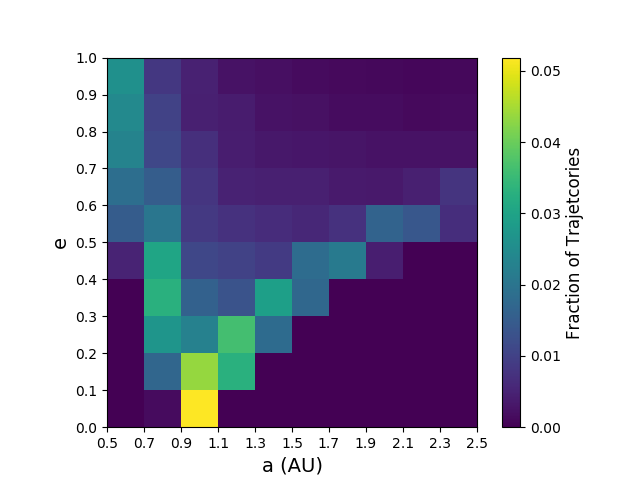

In [1078]:
fig=plt.figure()
ax=fig.gca()

im=ax.imshow(hae/Nt,origin='lower')
cbar=fig.colorbar(im)
cbar.ax.set_ylabel('Fraction of Trajetcories',fontsize=12)

ax.set_xlabel("a (AU)",fontsize=14)
ax.set_ylabel("e",fontsize=14)

xts=[]
xtl=[]
for i in np.arange(0.0,Na+1,1):
    xts+=[i-0.5]
    xtl+=["%.1f"%(amin+i*da)]
t=ax.set_xticks(xts)
t=ax.set_xticklabels(xtl)

xts=[]
xtl=[]
for i in np.arange(0.0,Ne+1,1):
    xts+=[i-0.5]
    xtl+=["%.1f"%(emin+i*de)]
t=ax.set_yticks(xts)
t=ax.set_yticklabels(xtl)

fig.savefig(BDIR+"FigurasArticulo/l21j-ae-map.png")
#ax.set_ylim((Ne-1,0))

## Maps of radiant in the sky

In [963]:
print(f"Computing map for radiant")
hs=data_rays[:,0]
As=data_rays[:,1]

Computing map for radiant


In [964]:
#Time of impact
t=spy.str2et("01/21/2019 04:41:38.000 UTC")
dt=spy.deltet(t,"ET")
et=t-dt
et

601317698.0

In [965]:
#Properties of the moon
n,rs=spy.bodvrd("MOON","RADII",3)
RMOON=rs[0]
FMOON=0.0

In [966]:
#Transformation from MOON to J2000
Moon2j2000=spy.pxform("IAU_MOON","J2000",et)

#Trasnformation from LOCAL to MOON
LON_MOON=-29.428816 #degrees, 29°25'43.74"S
LAT_MOON=-68.167435 #degrees, 68°10'2.77"O
ALT_MOON=0.510 #km
geopos=spy.georec(LON_MOON*DEG,LAT_MOON*DEG,ALT_MOON,RMOON,FMOON)
print(geopos)

normal=spy.surfnm(RMOON,RMOON,RMOON,geopos)

uz=np.array([0,0,1])
uy=spy.ucrss(uz,normal)
ux=spy.ucrss(normal,uy)

print(ux,uy,normal)

Local2Moon=np.array(np.vstack((ux,uy,normal)).transpose().tolist())
Moon2Local=np.linalg.inv(Local2Moon)
Moon2Local,Local2Moon

[  562.92405257  -317.56451019 -1613.25771686]
[ 0.80849637 -0.45610017  0.3718955 ] [ 0.49134185  0.87096681 -0.        ] [ 0.32390863 -0.18272782 -0.9282746 ]


(array([[ 0.80849637, -0.45610017,  0.3718955 ],
        [ 0.49134185,  0.87096681,  0.        ],
        [ 0.32390863, -0.18272782, -0.9282746 ]]),
 array([[ 0.80849637,  0.49134185,  0.32390863],
        [-0.45610017,  0.87096681, -0.18272782],
        [ 0.3718955 , -0.        , -0.9282746 ]]))

In [967]:
#Transform elevation and azimuth to a vector
Az=29.9670;h=19.2504;
#Az=0.0;h=0.0;
r_local=spy.latrec(1,Az*DEG,h*DEG)
#Az,h,
r_local

array([0.81787482, 0.47157238, 0.32969724])

In [968]:
spy.mxv(Local2Moon,r_local)

array([ 0.99974385, -0.02255381, -0.00188561])

In [969]:
#Transform vector from local to IAU moon
r_moon=spy.mxv(Local2Moon,r_local)
r_j2000=spy.mxv(Moon2j2000,r_moon)
r_local,r_moon,r_j2000

(array([0.81787482, 0.47157238, 0.32969724]),
 array([ 0.99974385, -0.02255381, -0.00188561]),
 array([ 0.50715505, -0.79073032, -0.34284008]))

In [970]:
#Transform from rectangular coordinates to 
r,RA,DEC=spy.reclat(r_j2000)
RA=RA+2*np.pi if RA<0 else RA
RA*RAD/15,DEC*RAD
#RA*RAD,DEC*RAD

(20.178341187799294, -20.050001973147314)

In [985]:
#Convert Az,h into RA, DEC at a location lon,lat,alt on the moon
def loc2Sky(et,Az,h,lon,lat,alt,bodyid="MOON",frameid="IAU_MOON"):
    """
    Az,h,lon,lat in degress.
    alt in km.
    
    Return RA(deg) and DEC(deg)
    
    Example: 
        Az=29.9670;h=19.2504
        loc2Sky(et,Az,h,LON_MOON,LAT_MOON,ALT_MOON,"MOON","IAU_MOON")
    """
    #Rectangular position
    r_local=spy.latrec(1,Az*DEG,h*DEG)
    
    #Size of the object
    n,rs=spy.bodvrd("MOON","RADII",3)
    Re=rs[0];Rp=rs[2]
    f=(Re-Rp)/Re
    geopos=spy.georec(lon*DEG,lat*DEG,alt,Re,f)

    #Local to Body reference frame transformation
    normal=spy.surfnm(Re,Re,Rp,geopos)
    uy=spy.ucrss(np.array([0,0,1]),normal)
    ux=spy.ucrss(normal,uy)
    Local2Body=np.array(np.vstack((ux,uy,normal)).transpose().tolist())
    
    #Body to J2000
    Body2j2000=spy.pxform(frameid,"J2000",et)
    
    #Transform vector from local to IAU moon
    r_body=spy.mxv(Local2Body,r_local)
    r_j2000=spy.mxv(Body2j2000,r_body)

    #J2000 coordinates
    r,RA,DEC=spy.reclat(r_j2000)
    RA=RA+2*np.pi if RA<0 else RA
    return RA*RAD,DEC*RAD    

In [987]:
print(f"Computing map for radiant")
#Conditions
hs=data_rays[:,0]
As=data_rays[:,1]
#Time of impact
t=spy.str2et("01/21/2019 04:41:38.000 UTC")
dt=spy.deltet(t,"ET")
et=t-dt

Computing map for radiant


In [1004]:
from tqdm import tqdm

In [1046]:
RAmin=0.0;RAmax=360;NRA=10;dRA=(RAmax-RAmin)/NRA
DECmin=-90.0;DECmax=90.0;NDEC=10;dDEC=(DECmax-DECmin)/NDEC

#Run over all combinations
hrd=np.zeros((NDEC,NRA))

j=0
for i in tqdm(range(len(data_rays))):

    #Topocentric coordinates
    Az=data_rays[i,1]
    h=data_rays[i,0]

    #J2000 coordinates
    RA,DEC=loc2Sky(et,Az,h,LON_MOON,LAT_MOON,ALT_MOON,"MOON","IAU_MOON")
    #print(Az,h,RA/15,DEC)
    
    nRA=int((RA-RAmin)/dRA)
    nDEC=int((DEC-DECmin)/dDEC)

    if nRA>=NRA or nDEC>=NDEC:continue
    hrd[nDEC,nRA]+=1
    j+=1


100%|██████████| 29467/29467 [00:16<00:00, 1810.96it/s]


In [1064]:
hrd/=hrd.sum()

In [1065]:
#Surface of the moon
sRA=[]
sDEC=[]
h=0
for Az in np.linspace(0,360,100):
    RA,DEC=loc2Sky(et,Az,h,LON_MOON,LAT_MOON,ALT_MOON,"MOON","IAU_MOON")
    sRA+=[RA]
    sDEC+=[DEC]
sRA=np.array(sRA);sDEC=np.array(sDEC)

In [1066]:
RA_EARTH=20+11.0/60.0+9.58/3600.0
DEC_EARTH=-(20+1.0/60.0+24.2/3600.0)
RAs,DECs=np.meshgrid(np.arange(RAmin,RAmax,dRA),np.arange(DECmin,DECmax,dDEC))

<IPython.core.display.Javascript object>


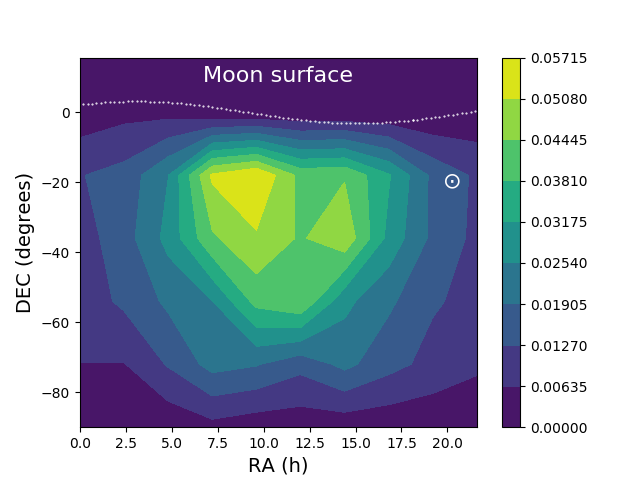

In [1077]:
fig=plt.figure()
ax=fig.gca()

c=ax.contourf(RAs/15.0,DECs,hrd,levels=np.linspace(hrd.min(),hrd.max(),10))
fig.colorbar(c)

#ax.plot(RA_EARTH,DEC_EARTH,'wo')
ax.plot(sRA/15.0,sDEC,'w.',ms=1)

ax.set_ylim((-90.0,5*max(sDEC)))
ax.set_xlim((0,RAs.max()/15.0))

ax.text(RA_EARTH,DEC_EARTH,r'$\odot$',ha='center',va='center',color='w',fontsize=16)
ax.text(0.5,0.95,"Moon surface",ha='center',va='center',transform=ax.transAxes,color='w',fontsize=16)

ax.set_xlabel("RA (h)",fontsize=14)
ax.set_ylabel("DEC (degrees)",fontsize=14)

fig.savefig(BDIR+"FigurasArticulo/l21j-RA_DEC-map.png")

## Photometry

In [313]:
stars=pd.read_csv(BDIR+"Data/photometry.csv")
for key in "B","V","G":stars[key]=stars[key].apply(lambda x:x.replace(',','.'))
impact=stars.loc[9].copy()
stars.drop(9,inplace=True)

In [326]:
coefs=[]
coefs+=[24.35475129]
coefs+=[0.17248805]
coefs+=[0.44909602]
coefs+=[1.93560511]
Gmag(coefs,stars.loc[0,"Red"],stars.loc[0,"Blue"],stars.loc[0,"Green"]), Gmag2(coefs,stars.loc[0,"Red"],stars.loc[0,"Blue"],stars.loc[0,"Green"])

(47.64725093167365, -0.8128008531195974)

In [327]:
chiSquare(coefs,stars,True)

BD+20 2009:Teo=45.87234458642629,Obs=10.4423,dM=35.43004458642629
BD+20 2007:Teo=46.69281649382823,Obs=9.7906,dM=36.902216493828234
BD+20 2005:Teo=47.71103846801377,Obs=8.6293,dM=39.08173846801377
BD+21 1766:Teo=47.903476152854815,Obs=8.3523,dM=39.551176152854815
BD+21 1779:Teo=47.684458586836044,Obs=8.9471,dM=38.737358586836045
BD+21 1777:Teo=46.387141930648745,Obs=9.6792,dM=36.707941930648744
TYC 1385-899-1:Teo=45.681138579078805,Obs=10.0131,dM=35.668038579078804
TYC 1385-939-1:Teo=44.62320087709288,Obs=10.3526,dM=34.270600877092875


4401391.387973822

In [650]:
solution=minimize(chiSquare,coefs,args=(stars,False),tol=1e-5)
solution

      fun: 6.602885449167282
 hess_inv: array([[ 0.06378907,  0.00068642, -0.00071408, -0.00731201],
       [ 0.00068642,  0.01668852,  0.00753168, -0.02450347],
       [-0.00071408,  0.00753168,  0.00496006, -0.0124912 ],
       [-0.00731201, -0.02450347, -0.0124912 ,  0.03812656]])
      jac: array([0.00000000e+00, 1.57356262e-05, 3.75509262e-06, 1.51991844e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 203
      nit: 10
     njev: 32
   status: 2
  success: False
        x: array([23.66202139,  0.18580187,  0.75506325, -2.56553377])

In [651]:
chiSquare(solution.x,stars,verbose=True)

BD+20 2009:Teo=10.40336964795436,Obs=10.4423,dM=0.03893035204563944
BD+20 2007:Teo=9.831578774493131,Obs=9.7906,dM=0.04097877449313181
BD+20 2005:Teo=8.708465595281524,Obs=8.6293,dM=0.07916559528152334
BD+21 1766:Teo=8.312023963832225,Obs=8.3523,dM=0.040276036167774976
BD+21 1779:Teo=8.918349790545427,Obs=8.9471,dM=0.028750209454573294
BD+21 1777:Teo=9.622782118746109,Obs=9.6792,dM=0.05641788125389091
TYC 1385-899-1:Teo=10.049968503648941,Obs=10.0131,dM=0.03686850364894134
TYC 1385-939-1:Teo=10.359961545878686,Obs=10.3526,dM=0.00736154587868576


6.602885449167282

In [652]:
m=Gmag(solution.x,impact["Red"],impact["Blue"],impact["Green"],impact["Row"],impact["Col"])
print(f"Magnitude without exposure correction:",m)

Magnitude without exposure correction: 11.608517707928296


In [654]:
TSTARS=20.0
TFLASH=9.0/30.0

In [655]:
G=m-2.5*np.log10(TSTARS/TFLASH)
G

7.048745855567499

In [656]:
#Filter calibration properties
NG=2.500e-11 #W/m^2/nm
G0=0.03
DLAMBDA=420.360 #nm
f=2

In [631]:
#Luminous energy
Er=NG*10**((-G+G0)/2.5)*DLAMBDA*f*np.pi*(MOON_DISTANCE*1e3)**2
np.log10(Er)

7.119390574456247

In [632]:
#Error in luminous energy
Gr=np.random.normal(G,0.05,1000)
Err=NG*10**((-Gr+G0)/2.5)*DLAMBDA*f*np.pi*(MOON_DISTANCE*1e3)**2

In [633]:
logEr=np.log10(Err).mean()

In [634]:
dlogEr=np.log10(Err).std()
dlogEr

0.02006081794831549

In [661]:
10**(logEr+dlogEr)/1e7,10**(logEr-dlogEr)

(1.382983865836978, 12609430.65682911)

In [638]:
logeta_min=np.log10(1.8e-3)
logeta_max=np.log10(3.4e-3)
logeta_mean=(logeta_min+logeta_max)/2
dlogeta=logeta_mean-logeta_min
logeta_min,logeta_mean,logeta_max,dlogeta

(-2.744727494896694,
 -2.6066242889272195,
 -2.468521082957745,
 0.13810320596947445)

In [640]:
logK=logEr-logeta_mean
dlogK=max(dlogEr,dlogeta)
logK,dlogK

(9.727380584552536, 0.13810320596947445)

In [663]:
## Tons of TNT
ttnt=4.184e9 #J
10**(logK-dlogK)/ttnt,10**(logK+dlogK)/ttnt

(0.9282943405226756, 1.7534448654317127)

## Meteoroid and crater size

In [641]:
#Regolith density
rhot=1600 #kg/m^3

In [642]:
N=1000
#Random kinetic energy
logKs=np.random.normal(logK,dlogK,N)
Ks=10**logKs
#Random impact speed
vrs=randomX(vimps,pvs,N)
#Random impact angle
thetas=randomX(angles,pas,N)
#Random densities
u=np.random.rand(N)
rhos=np.zeros(N)
rhos[(u<0.01)]=1000
rhos[(u>=0.01)*(u<0.59)]=2500
rhos[(u>=0.59)]=3700
#Ks,vrs,thetas,rhos

In [643]:
#Mass
Ms=2*Ks/(vrs*1e3)**2
logMs=np.log10(Ms)
#Diameter
Ds=2*(3*Ms/(3*np.pi*rhos))**(1./3)
#Crater diameter
dcs=0.25*rhos**(1./6.)*rhot**(-0.5)*Ks**0.29*(np.sin(thetas*DEG))**(1./3.)

In [647]:
#Basic statistics
np.percentile(Ms,50),np.percentile(Ds,50),np.percentile(dcs,50)

(62.69778236769954, 0.3796371553573257, 12.83029560743919)

In [648]:
properties=[
    dict(name="$\log(M)$",units="[kg]",symbol="logMs",xlabel=r"$\log(M)$ (kg)",ylabel=r"$p(\log M)$"),
    dict(name="$D$",units="m",symbol="Ds",xlabel=r"$D$ (m)",ylabel=r"$p(D)$"),
    dict(name="$d$",units="m",symbol="dcs",xlabel=r"$d$ (m)",ylabel=r"$p(d)$"),
]

In [649]:
plt.ioff()
for q in properties[:]:
    
    print(f"Generating statistics of {q['symbol']}...")
    
    #Statistics
    exec(f"vs=deepcopy({q['symbol']})")
    exec(f"hs,xs=np.histogram({q['symbol']},100,normed=True)")
    xms=(xs[1:]+xs[:-1])/2
    #Error
    x1,xm,x2=np.percentile(vs,[15,50,85])
    mv=xm-x1;pv=x2-xm
    x1,xm,x2

    #Plot distributions
    fig=plt.figure()
    ax=fig.gca()
    ax.step(xms,hs,color='r',lw=2)

    ax.set_xlabel(q["xlabel"],fontsize=14)
    ax.set_ylabel(q["ylabel"],fontsize=14)

    ax.axvspan(x1,xm,color='k',alpha=0.3)
    ax.axvline(xm,color='k',lw=2)
    ax.axvspan(xm,x2,color='k',alpha=0.3)

    ax.text(0.5,0.1,r"%s$=%.1lf^{+%.1lf}_{-%.1lf}$ %s"%(q["name"],xm,mv,pv,q["units"]),
            transform=ax.transAxes,ha='center',va='center',fontsize=14,bbox=dict(facecolor='lightgray'))

    ymin,ymax=ax.get_ylim()
    ax.set_ylim((0,ymax))
    ax.set_xlim((x1-2*mv,x2+2*pv))
    fname=BDIR+f"FigurasArticulo/l21j-{q['symbol']}-ppd.png"
    print(f"\tCreating figure file {fname}")
    fig.savefig(fname)
    fig.tight_layout()
    del(fig)

Generating statistics of logMs...


/Users/jzuluaga/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  """Entry point for launching an IPython kernel.
/Users/jzuluaga/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


	Creating figure file ./FigurasArticulo/l21j-logMs-ppd.png
Generating statistics of Ds...
	Creating figure file ./FigurasArticulo/l21j-Ds-ppd.png
Generating statistics of dcs...
	Creating figure file ./FigurasArticulo/l21j-dcs-ppd.png


In [662]:
10**(1.8+0.4),10**(1.8-0.4)

(158.48931924611142, 25.118864315095795)